In [1]:
#### python_ncut_lib.py
# Copyright (C) 2010 R. Cameron Craddock (cameron.craddock@gmail.com)
#
# This script is a part of the pyClusterROI python toolbox for the spatially
# constrained clustering of fMRI data. It provides the library functions for
# performing normalized cut clustering according to:
#
# Stella Yu and Jianbo Shi, "Understanding Popout through Repulsion," Computer
# Vision and Pattern Recognition, December, 2001.  
#
# Shi, J., & Malik, J. (2000).  Normalized cuts and image segmentation. IEEE
# Transactions on Pattern Analysis and Machine Intelligence, 22(8), 888-905.
# doi: 10.1109/34.868688.
#
# Yu, S. X., & Shi, J. (2003). Multiclass spectral clustering. Proceedings Ninth
# IEEE International Conference on Computer Vision, (1), 313-319 vol.1. Ieee.
# doi: 10.1109/ICCV.2003.1238361.
#
# This code is a port of the NcutClustering_7 matlab toolbox available here:
# http://www.cis.upenn.edu/~jshi/software/
#
# For more information refer to:
#
# Craddock, R. C.; James, G. A.; Holtzheimer, P. E.; Hu, X. P. & Mayberg, H. S.
# A whole brain fMRI atlas generated via spatially constrained spectral
# clustering Human Brain Mapping, 2012, 33, 1914-1928 doi: 10.1002/hbm.21333.
#
# ARTICLE{Craddock2012,
#   author = {Craddock, R C and James, G A and Holtzheimer, P E and Hu, X P and
#   Mayberg, H S},
#   title = {{A whole brain fMRI atlas generated via spatially constrained
#   spectral clustering}},
#   journal = {Human Brain Mapping},
#   year = {2012},
#   volume = {33},
#   pages = {1914--1928},
#   number = {8},
#   address = {Department of Neuroscience, Baylor College of Medicine, Houston,
#       TX, United States},
#   pmid = {21769991},
# } 
#
# Documentation, updated source code and other information can be found at the
# NITRC web page: http://www.nitrc.org/projects/cluster_roi/ and on github at
# https://github.com/ccraddock/cluster_roi
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
####

# this scripts requires NumPy (numpy.scipy.org) and SciPy (www.scipy.org) to be
# installed in a directory that is accessible through PythonPath 
import sys
import matplotlib.pyplot as plt
from numpy import array, reshape, shape, matrix, ones, zeros, sqrt
from numpy import argsort, sign, kron, multiply, divide, abs, asarray
from scipy import rand
from scipy.sparse import csc_matrix, spdiags
from scipy.sparse.linalg import eigsh
from scipy.linalg import norm, svd, LinAlgError
from utils import read_EM

# exception hander for singular value decomposition
class SVDError(Exception):
    def __init__(self,value):
        self.value=value
    def __str__(self):
        return repr(self.value)


# (eigen_val, eigen_vec) = ncut( W, nbEigenValues ):
#
# This function performs the first step of normalized cut spectral clustering.
# The normalized LaPlacian is calculated on the similarity matrix W, and top
# nbEigenValues eigenvectors are calculated. The number of eigenvectors
# corresponds to the maximum number of classes (K) that will be produced by the
# clustering algorithm. 
#
#    W:             symmetric #feature x #feature sparse matrix representing the
#                   similarity between voxels, traditionally this matrix should
#                   be positive semidefinite, but regularization is employed to
#                   allow negative matrix entries (Yu 2001)
#    nvEigenValues: number of eigenvectors that should be calculated, this
#                   determines the maximum number of clusters (K) that can be
#                   derived from the
#    result
#    eigen_val:     (output) eigenvalues from the eigen decomposition of the
#                   LaPlacian of W
#    eigen_vec:     (output) eigenvectors from the eign decomposition of the
#                   LaPlacian of W
#
def ncut( W, nbEigenValues ):
    # parameters
    offset=.5
    maxiterations=100
    eigsErrorTolerence=1e-6
    eps=2.2204e-16

    m=shape(W)[1]

    # make sure that W is symmetric, this is a computationally expensive
    # operation, only use for debugging
    # if (W-W.transpose()).sum() != 0:
    #    print "W should be symmetric!"
    #    exit(0)

    # degrees and regularization
    # S Yu Understanding Popout through Repulsion CVPR 2001
    # Allows negative values as well as improves invertability of d for small
    # numbers i bet that this is what improves the stability of the eigen
    d=abs(W).sum(0)
    dr=0.5*(d-W.sum(0))
    d=d+offset*2
    dr=dr+offset

    # calculation of the normalized LaPlacian
    W=W+spdiags(dr,[0],m,m,"csc")
    Dinvsqrt=spdiags((1.0/sqrt(d+eps)),[0],m,m,"csc")
    P=Dinvsqrt*(W*Dinvsqrt);

    # perform the eigen decomposition
    eigen_val,eigen_vec=eigsh(P,nbEigenValues,maxiter=maxiterations,\
        tol=eigsErrorTolerence,which='LA')

    # sort the eigen_vals so that the first
    # is the largest
    i=argsort(-eigen_val)
    eigen_val=eigen_val[i]
    eigen_vec=eigen_vec[:,i]

    # normalize the returned eigenvectors
    eigen_vec=Dinvsqrt*matrix(eigen_vec)
    norm_ones=norm(ones((m,1)))
    for i in range(0,shape(eigen_vec)[1]):
        eigen_vec[:,i]=(eigen_vec[:,i] / norm(eigen_vec[:,i]))*norm_ones
        if eigen_vec[0,i] != 0:
            eigen_vec[:,i] = -1 * eigen_vec[:,i] * sign( eigen_vec[0,i] )

    return(eigen_val, eigen_vec)

# eigenvec_discrete=discretisation( eigen_vec ):
#
# This function performs the second step of normalized cut clustering which
# assigns features to clusters based on the eigen vectors from the LaPlacian of
# a similarity matrix. There are a few different ways to perform this task. Shi
# and Malik (2000) iteratively bisect the features based on the positive and
# negative loadings of the eigenvectors. Ng, Jordan and Weiss (2001) proposed to
# perform K-means clustering on the rows of the eigenvectors. The method
# implemented here was proposed by Yu and Shi (2003) and it finds a discrete
# solution by iteratively rotating a binaised set of vectors until they are
# maximally similar to the the eigenvectors (for more information, the full
# citation is at the top of this file). An advantage of this method over K-means
# is that it is _more_ deterministic, i.e. you should get very similar results
# every time you run the algorithm on the same data.
#
# The number of clusters that the features are clustered into is determined by
# the number of eignevectors (number of columns) in the input array eigen_vec. A
# caveat of this method, is that number of resulting clusters is bound by the
# number of eignevectors, but it may contain less.
#
#    eigen_vec:          Eigenvectors of the normalized LaPlacian calculated
#                        from the similarity matrix for the corresponding
#                        clustering problem
#    eigen_vec_discrete: (output) discretised eigenvectors, i.e. vectors of 0
#                        and 1 which indicate whether or not a feature belongs
#                        to the cluster defined by the eigen vector.  I.E. a one
#                        in the 10th row of the 4th eigenvector (column) means
#                        that feature 10 belongs to cluster #4.
# 
def discretisation( eigen_vec ):
    eps=2.2204e-16

    # normalize the eigenvectors
    [n,k]=shape(eigen_vec)
    vm=kron(ones((1,k)),sqrt(multiply(eigen_vec,eigen_vec).sum(1)))
    eigen_vec=divide(eigen_vec,vm)

    svd_restarts=0
    exitLoop=0

    ### if there is an exception we try to randomize and rerun SVD again
        ### do this 30 times
    while (svd_restarts < 30) and (exitLoop==0):

        # initialize algorithm with a random ordering of eigenvectors
        c=zeros((n,1))
        R=matrix(zeros((k,k)))
        R[:,0]=eigen_vec[int(rand(1)*(n-1)),:].transpose()

        for j in range(1,k):
            c=c+abs(eigen_vec*R[:,j-1])
            R[:,j]=eigen_vec[c.argmin(),:].transpose()


        lastObjectiveValue=0
        nbIterationsDiscretisation=0
        nbIterationsDiscretisationMax=20

        # iteratively rotate the discretised eigenvectors until they
        # are maximally similar to the input eignevectors, this 
        # converges when the differences between the current solution
        # and the previous solution differs by less than eps or we
        # we have reached the maximum number of itarations
        while exitLoop == 0:
            nbIterationsDiscretisation = nbIterationsDiscretisation + 1

            # rotate the original eigen_vectors
            tDiscrete=eigen_vec*R

            # discretise the result by setting the max of each row=1 and
            # other values to 0
            j=reshape(asarray(tDiscrete.argmax(1)),n)
            eigenvec_discrete=csc_matrix((ones(len(j)),(range(0,n), \
                array(j))),shape=(n,k))

            # calculate a rotation to bring the discrete eigenvectors cluster to
            # the original eigenvectors
            tSVD=eigenvec_discrete.transpose()*eigen_vec
            # catch a SVD convergence error and restart
            try:
                U, S, Vh = svd(tSVD)
            except LinAlgError:
                # catch exception and go back to the beginning of the loop
                print >> sys.stderr, \
                    "SVD did not converge, randomizing and trying again"
                break

            # test for convergence
            NcutValue=2*(n-S.sum())
            if((abs(NcutValue-lastObjectiveValue) < eps ) or \
                      ( nbIterationsDiscretisation > \
                        nbIterationsDiscretisationMax )):
                exitLoop=1
            else:
                # otherwise calculate rotation and continue
                lastObjectiveValue=NcutValue
                R=matrix(Vh).transpose()*matrix(U).transpose()

    if exitLoop == 0:
        raise SVDError("SVD did not converge after 30 retries")
    else:
        return(eigenvec_discrete)


In [6]:
import numpy as np
import math
import pdb
import tqdm

def ncut_graph_matrix(im,sigma_d=5e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    im1 = im.reshape((N, 1))
    im1 = np.repeat(im1, N, axis=1)
    im2 = np.transpose(im1)
    
    xx,yy = np.meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    yx = np.stack([y, x], axis=1)
    yx = np.expand_dims(yx, axis=0)
    yx = np.repeat(yx, N, axis=0)
    xy = np.transpose(yx, axes=[1, 0, 2])
    dis = np.sqrt(np.sum(1.0*(xy-yx)**2, axis=2))
    W = np.multiply( np.exp(-1.0*np.sqrt((im1-im2)**2)/sigma_g), np.exp(-dis/sigma_d) )
    return W
    

In [37]:
x_train, t_train, x_test = read_EM('./Dataset/')
idx = 1
img = x_train[1, 0:56, 0:56]
target = t_train[1, 0:56, 0:56]
W = ncut_graph_matrix(img, sigma_d=1e2, sigma_g=1e-2)

In [38]:
val, vec = ncut(W, 2)
vec = discretisation(vec)
vec = vec.toarray()

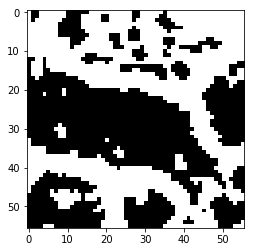

In [39]:
%matplotlib inline
a = vec[:, 0].reshape((56, 56))

plt.imshow(a, cmap='gray')
plt.show()

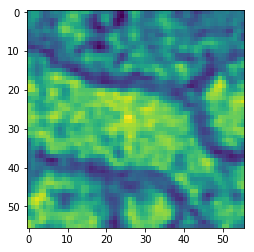

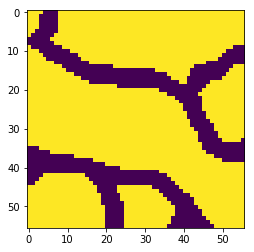

In [40]:
%matplotlib inline

plt.imshow(img[0:56, 0:56])
plt.show()
plt.imshow(target[0:56, 0:56])
plt.show()

In [1]:
import tensorflow as tf

In [5]:
tmp = tf.ones((2, 2, 2), dtype=tf.float32)
sess = tf.Session()
sess.run((1/2)*tmp)

array([[[ 0.5,  0.5],
        [ 0.5,  0.5]],

       [[ 0.5,  0.5],
        [ 0.5,  0.5]]], dtype=float32)